# STR459 EXAM
## Predicting Wine Quality with ML Models
Candidate numbers: 5, 32, 33, 37, 48

This project will focus on the chemical properties of wine, and by applying relevant applications of machine learning, we will try to create a model which can predict the wine quality of a given wine sample based.

In [1]:
# Loading packages
import pandas as pd                    # Data handling
import numpy as np                     # Data science tool
import datetime                        # Date handling
import matplotlib.pyplot as plt        # Plots
import seaborn as sns                  # Graphical plot improvements
import os                              # Accessing file directories on the computer
import urllib.request                  # Download files from a url
import matplotlib.cm as cm             # Confusion Matrix
import warnings                        # Suppress unnecessary warnings

In [2]:
# Machine learning packages
from sklearn.model_selection import train_test_split             # Splitting data between test and train sets
from sklearn.preprocessing import LabelEncoder                   # Used to change continious variable to categorical
from sklearn.metrics import accuracy_score, precision_score      # Accuracy score function
from sklearn.metrics import confusion_matrix                     # Confusion Matrix
from sklearn.model_selection import RandomizedSearchCV           # Randomized Search on hyper paramters
from sklearn.tree import DecisionTreeClassifier                  # The decision tree function
from sklearn.ensemble import RandomForestClassifier              # The random forest function
from sklearn.neighbors import KNeighborsClassifier               # The KNN function
from sklearn.metrics import roc_curve, roc_auc_score, auc        # ROC-curve
from sklearn.model_selection import cross_val_score              # Cross Validation Score
from sklearn.linear_model import LogisticRegression              # Logistic Regression
from sklearn.model_selection import GridSearchCV                 # Grid Search
from sklearn.exceptions import ConvergenceWarning                # Suppress unnecessary warnings

In [3]:
# Formatting options
# Setting display setting for float numbers
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Defining colors used in the project
blue_color = 'steelblue'
red_color = 'indianred'

### Importing and cleaning the data
The data is sourced from UCI's Machine Learning archive:
https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/

In [4]:
# Download the dataset used for this task
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
path = 'data'

if not os.path.exists(path):
    os.makedirs(path)

filename = os.path.join(path, url.split('/')[-1])
urllib.request.urlretrieve(url, filename)

print(f'{filename} saved successfully!')

data/winequality-white.csv saved successfully!


In [5]:
# List the files present in the directory
files = os.listdir(path)

#Print the file names
print(files)

['market_data', 'winequality-white.csv']


In [6]:
# Importing the data
df_raw = pd.DataFrame()

for i in files:
    if i.endswith(".csv"):
        file_path = "data/" + i
        temp_df = pd.read_csv(file_path, sep = ";")
        temp_df['filename'] = i
        df_raw = pd.concat([df_raw, temp_df], ignore_index=True)

# Displaying the data
df_raw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,filename
0,7.000,0.270,0.360,20.700,0.045,45.000,170.000,1.001,3.000,0.450,8.800,6,winequality-white.csv
1,6.300,0.300,0.340,1.600,0.049,14.000,132.000,0.994,3.300,0.490,9.500,6,winequality-white.csv
2,8.100,0.280,0.400,6.900,0.050,30.000,97.000,0.995,3.260,0.440,10.100,6,winequality-white.csv
3,7.200,0.230,0.320,8.500,0.058,47.000,186.000,0.996,3.190,0.400,9.900,6,winequality-white.csv
4,7.200,0.230,0.320,8.500,0.058,47.000,186.000,0.996,3.190,0.400,9.900,6,winequality-white.csv


### Descriptive Analysis

In [7]:
# Checking if there is any NA values
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
 12  filename              4898 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 497.6+ KB


### Figure 1 - Variable Distributions

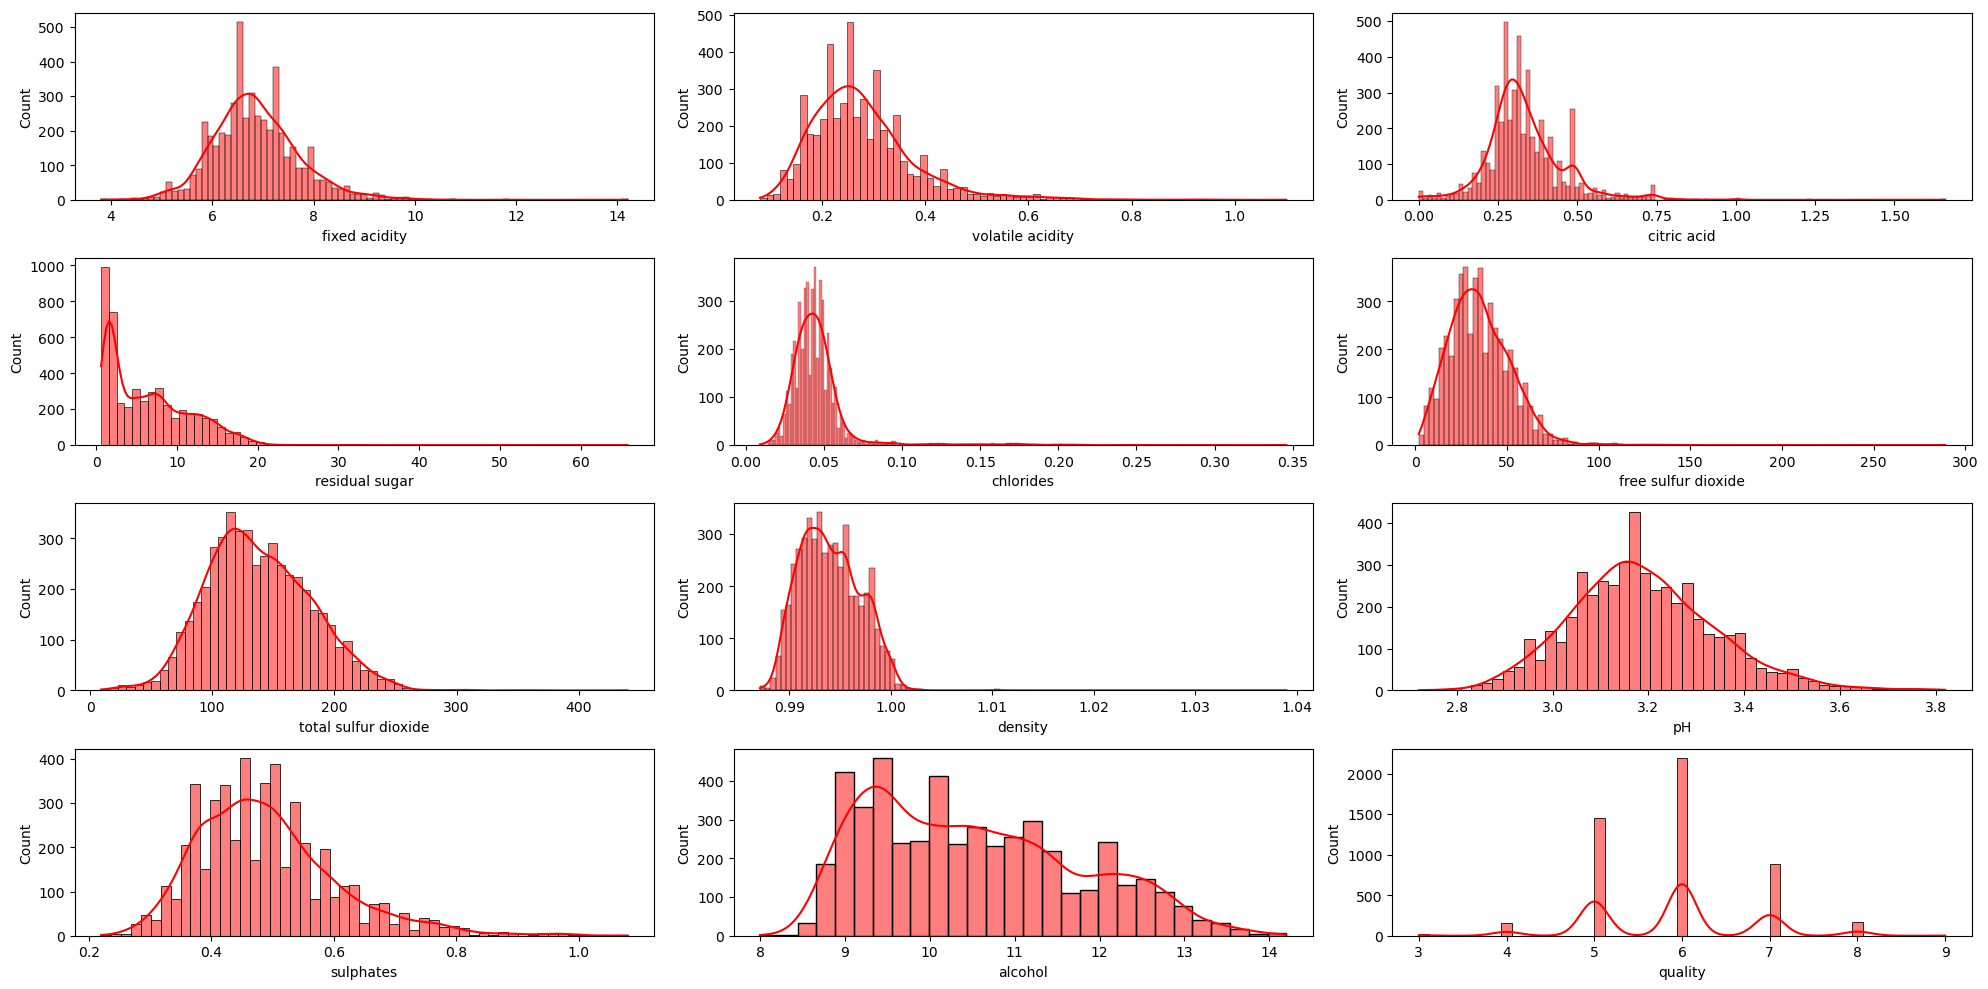

In [8]:
# Data distribution visualization
fig = plt.figure(figsize = [20,10])
cols = df_raw.columns.drop('filename')
i = 1

for col in cols:
    plt.subplot(4,3,i)
    sns.histplot(df_raw[col], kde=True, color="red", edgecolor="black")
    i=i+1
plt.tight_layout()
plt.savefig('plots/value_counts.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Creating a dataframe with the skew of the variables
skew = pd.DataFrame({'skew': df_raw.skew(numeric_only=True)})

# create a new dataframe with kurtosis as columns
kurt = pd.DataFrame({'kurtosis': df_raw.kurtosis(numeric_only=True)})

# append kurtosis values to original dataframe
df_dist = pd.concat([skew, kurt], axis=1)

# Display results
df_dist

,skew,kurtosis
fixed acidity,0.648,2.172
volatile acidity,1.577,5.092
citric acid,1.282,6.175
residual sugar,1.077,3.470
chlorides,5.023,37.565
free sulfur dioxide,1.407,11.466
total sulfur dioxide,0.391,0.572
density,0.978,9.794
pH,0.458,0.531
sulphates,0.977,1.591


### Figure 2 - Central Tendencies of Variables and Count

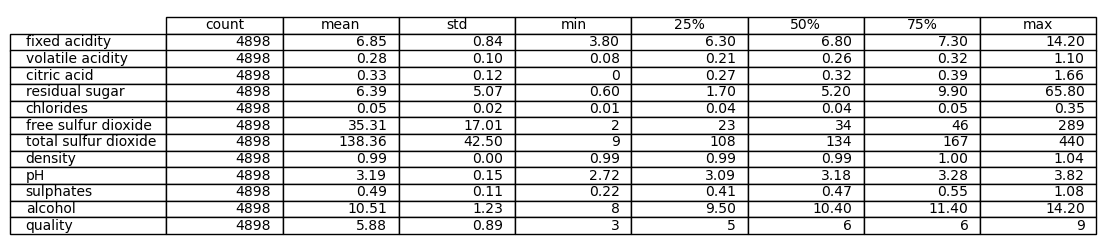

In [10]:
# Describing the various data points in the dataset
descriptive_stats = df_raw.describe().transpose().applymap(lambda x: f'{x:.0f}' if x == int(x) else f'{x:.2f}')

fig, ax = plt.subplots(figsize=(12, 3))
ax.axis('off')
ax.axis('tight')
ax.table(cellText=descriptive_stats.values,
         colLabels=descriptive_stats.columns,
         rowLabels=descriptive_stats.index,
         loc='center')
plt.savefig('plots/central_tendency.png', dpi=300, bbox_inches='tight')
plt.show()

### Figure 3 - Correlation Matrix

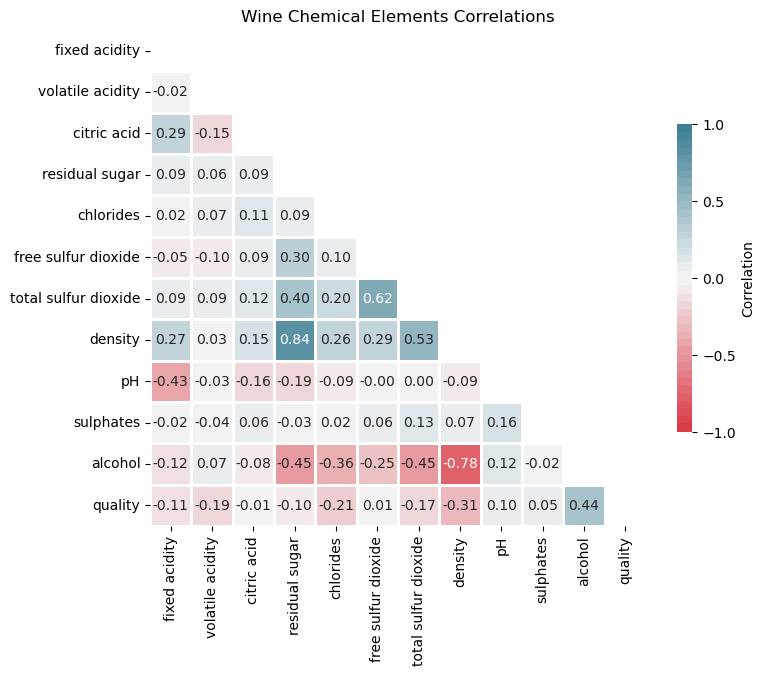

In [11]:
# Correlation Matrix
# Calculate the correlation matrix
corr = df_raw.corr()

# Create a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Define a custom color palette
cmap = sns.diverging_palette(10, 220, sep=10, n=40)

# Defining the size of the Figure
plt.figure(figsize=(8,8))

# Plot the heatmap with mask, custom color palette and annotations
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=1,
            cbar_kws={"shrink": .5, "ticks":[-1,-0.5,0,0.5,1], "label": "Correlation"},
            annot=True, fmt=".2f", vmin=-1, vmax=1)

# Adding Title
plt.title('Wine Chemical Elements Correlations')

# Save figure as PNG file
plt.savefig('plots/corr_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

It seems like most of the observations of quality are either 5, 6 or 7. This might impact he models ability to identify outliers, and should be taken into account when analysing the output of the model.

### Data Wrangling in light of Descriptive Statistics

In [12]:
# The density value was highly correlated with several values (corr > 0.7).
# In order to avoid colinearity, we remove this column from the data
df_raw = df_raw.drop("density", axis = 1)

## Business Case
This part shows the data wrangling and plotting of the market data used in the business case in section 4.2 in the project.
Sources of data:
 - Revenue of the wine market in Europe from 2012 to 2025 (Dollars): https://www.statista.com/forecasts/1242555/europe-wine-market-revenue
 - GDP of Europe 1995-2021: https://www.statista.com/statistics/279447/gross-domestic-product-gdp-in-the-european-union-eu/

In [13]:
# List the files present in the directory
files_market = os.listdir("data/market_data")

#Print the file names
print(files_market)

['eu_wine_dollar.xlsx', 'eu_gdp.xlsx']


In [14]:
# Creating an empty Data Frame (only containing years)
df_wine = pd.DataFrame({'year': range(1970, 2023)})
df_wine["year"] = df_wine["year"].astype("str")

# Importing the Wine Market Data
for i in files_market:
    if i.endswith(".xlsx"):
        df_temp = pd.read_excel("data/market_data/"+i,
                        sheet_name = "Data").drop("Unnamed: 0", axis = 1)
        df_temp.columns = ["year", i.replace('.xlsx', '')]
        df_temp = df_temp.iloc[4:]
        df_wine = df_wine.merge(df_temp, on=['year'], how='left')
        
df_wine = df_wine.dropna().reset_index(drop=True)

# Converting the eu_wine_dollar to eu_wine which is measured in euro
# Average rate of Dollar to Euro 2019: 0.8931 USD/EUR
# Source: https://www.exchangerates.org.uk/USD-EUR-spot-exchange-rates-history-2019.html
usd_eur = 0.8931

df_wine["eu_wine"] = df_wine["eu_wine_dollar"]*usd_eur
df_wine = df_wine.drop("eu_wine_dollar", axis = 1)
df_wine

,year,eu_gdp,eu_wine
0,2012,11391843.700,155.578
1,2013,11520159.100,164.509
2,2014,11783874.300,168.617
3,2015,12214623.900,145.843
4,2016,12552500.000,146.915
5,2017,13076045.700,153.881
6,2018,13531477.000,162.991
7,2019,14017090.600,159.061
8,2020,13399689.600,129.321
9,2021,14447940.600,136.555


From here it is possible to define the size of the wine market compared to the GDP of the EU.

In [15]:
df_wine["eu_wine_gdp"] = (df_wine["eu_wine"]*1000000000)/(df_wine["eu_gdp"]*1000000)
df_wine

,year,eu_gdp,eu_wine,eu_wine_gdp
0,2012,11391843.700,155.578,0.014
1,2013,11520159.100,164.509,0.014
2,2014,11783874.300,168.617,0.014
3,2015,12214623.900,145.843,0.012
4,2016,12552500.000,146.915,0.012
5,2017,13076045.700,153.881,0.012
6,2018,13531477.000,162.991,0.012
7,2019,14017090.600,159.061,0.011
8,2020,13399689.600,129.321,0.010
9,2021,14447940.600,136.555,0.009


### Figure 8 - Wine Production in the EU (Statista, 2023)

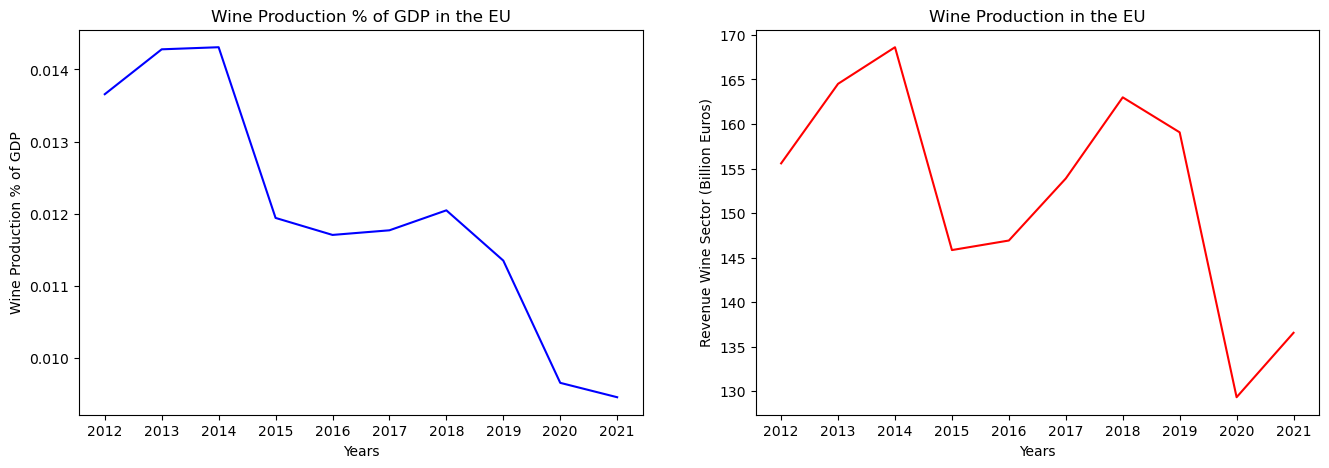

In [16]:
# Creating two plots which presents the total industry, and its share of the GDP
# of the EU economic area.
fig, ax = plt.subplots(1, 2, figsize = (16,5))

ax[0].plot(df_wine['year'], df_wine['eu_wine_gdp'], color="blue")
ax[1].plot(df_wine['year'], df_wine['eu_wine'], color="red")

ax[1].ticklabel_format(style='plain', axis='y')

ax[0].set_title("Wine Production % of GDP in the EU")
ax[0].set_ylabel("Wine Production % of GDP")
ax[0].set_xlabel("Years")

ax[1].set_title("Wine Production in the EU")
ax[1].set_ylabel("Revenue Wine Sector (Billion Euros)")
ax[1].set_xlabel("Years")

plt.savefig('plots/wine_market_eu.png', dpi=300, bbox_inches='tight')

plt.show()

# Machine Learning

In this part of the code our classification models will be implemented

In [17]:
# Creating df_main to not mess with the raw files and inputs
df_main = df_raw

Splitting into test and train set

In [18]:
# X contain input features that will be used to predicate in DecisionTreeClassifier, but also later with
# the other predicators used.
# Removes quality because it is used as the output, and filename because it is not used here.
X = df_main.drop(['quality', 'filename'], axis = 1)

# Changing continous to categorical and setting cut off to 5,5
le = LabelEncoder()
y = le.fit_transform(df_main['quality'] > 5.5)

# Splitting and accuracy with as split of 80/20. The splitting is done at random
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 123)

# Classification models

Creating functions for comparing default and tuned model

In [19]:
# The functions compare two models accuracy and precision for both test and training set

def compare_models(model1, model2, X_train, y_train, X_test, y_test):
    # Train both models on the training set
    model1.fit(X_train, y_train)
    model2.fit(X_train, y_train)
    
    # Make predictions for the train and test sets for both models
    y_train_pred_model1 = model1.predict(X_train)
    y_test_pred_model1 = model1.predict(X_test)
    
    y_train_pred_model2 = model2.predict(X_train)
    y_test_pred_model2 = model2.predict(X_test)
    

    models_metrix = {
        'model1' : {
            'train' : [accuracy_score(y_train, y_train_pred_model1),
                       precision_score(y_train, y_train_pred_model1)],
            'test' : [accuracy_score(y_test, y_test_pred_model1),
                      precision_score(y_test, y_test_pred_model1)]
        },
        
        'model2' : {
            'train' : [accuracy_score(y_train, y_train_pred_model2),
                       precision_score(y_train, y_train_pred_model2)],
            'test' : [accuracy_score(y_test, y_test_pred_model2),
                      precision_score(y_test, y_test_pred_model2)]
        }
    }

    return models_metrix


def present_results(models_metrix, model1_name, model2_name):
    
    row_names = ['Accuracy', 'Precision']

    df1 = pd.DataFrame({'Metric': row_names,
                        'Train': models_metrix['model1']['train'],
                        'Test' : models_metrix['model1']['test']})
    
    df2 = pd.DataFrame({'Metric': row_names,
                        'Train': models_metrix['model2']['train'],
                        'Test' : models_metrix['model2']['test']})
    
    print('Performance metrix:', model1_name)
    print(df1)
    print()
    print('Performance metrix:', model2_name)
    print(df2)
    


Creating function for confusion matrix output



In [20]:
def print_confusion(model, title):
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    cm = confusion_matrix(y_test, y_preds)
    
    plt.figure(figsize=(2,2))
    sns.heatmap(cm, annot=True, square = True, cmap = 'Paired', vmin = 0, vmax = 0, linewidths=0.5,
           linecolor='k', cbar = False, fmt='d', xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
    sns.despine(left=False, right=False, top=False, bottom=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    

    accuracy = round(model.score(X_test, y_test), 3)
    plt.suptitle(f"Accuracy: {accuracy:.3f}", fontsize=10, y=1.1)

    plt.title(title, fontweight="bold", fontsize=11)

    plt.savefig(f'plots/{title}.png', dpi=300, bbox_inches='tight')
   
    plt.show() 

## Decisiontreeclassifier

With the `DecisionTreeClassifier` from sklearn it is possible to solve classification problems. It builds a decision tree based on the input given. The decisiontree itself is used to predicate.

Create model based on tuning

In [21]:
# Create default model
dtc_def = DecisionTreeClassifier()

# Create model to tune
dtc = DecisionTreeClassifier()            


# Parameters to tune the model on
# Max depth of tree
max_depth = [3,5,7,9,10,15,20,25]
# Crtierion for measure quality of split
criterion = ['gini', 'entropy']
# Max features
max_features = ['sqrt']
# Minimum number of samples required to split a node
min_samples_split = [2,4,6]

# Dictionary containing parameters to tune
param_grid = {'max_depth': max_depth,
               'criterion': criterion,
               'max_features': max_features,
               'min_samples_split': min_samples_split}


# Set the random seed
np.random.seed(123)

# n_iter chosen for max number
dtc_RandomGrid = RandomizedSearchCV(estimator = dtc, param_distributions = param_grid, n_iter = 48, cv = 5, verbose=2, n_jobs = 4)
dtc_RandomGrid.fit(X_train, y_train)

# Tundes parameters
print('Tuned parameters:') 
print(dtc_RandomGrid.best_params_) 

# Create model with the tuned parameters
dtc_rand = DecisionTreeClassifier(min_samples_split = 2,
                                   max_features = 'sqrt',
                                   max_depth = 15,
                                   criterion = 'gini')




Fitting 5 folds for each of 48 candidates, totalling 240 fits
Tuned parameters:
{'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini'}


Checking performance for the two models

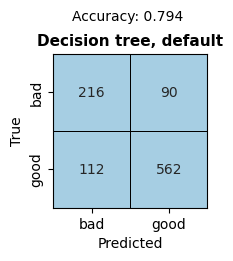

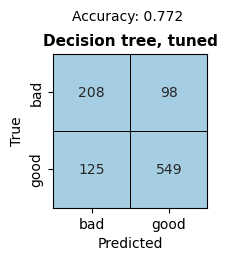

Performance metrix: Default model
      Metric  Train  Test
0   Accuracy  1.000 0.793
1  Precision  1.000 0.866

Performance metrix: Tuned model
      Metric  Train  Test
0   Accuracy  0.979 0.796
1  Precision  0.979 0.852


In [22]:
# Set the random seed
np.random.seed(123)
# General confusion matrix
print_confusion(dtc_def, 'Decision tree, default')
print_confusion(dtc_rand, 'Decision tree, tuned')

# Comparing models
metrixs = compare_models(dtc_def, dtc_rand, X_train, y_train, X_test, y_test)

present_results(metrixs, 'Default model', 'Tuned model')

For this seed looking only at accuracy and precision it does not seem that one model is better then the other. We will compare the overall performance of all models in the end.

# Random forest

Random forest combines multiple decision trees to make a final prediction

Creating model based on tuning



In [24]:
# Creating default
rfc_def = RandomForestClassifier()

# Model to tune
rfc = RandomForestClassifier()



# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [3,5]
# Minimum number of samples required to split a node
min_samples_split = [3, 6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the param grid (RF)
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Set the random seed
np.random.seed(123)

# Tuning optimazation
rf_RandomGrid = RandomizedSearchCV(estimator = rfc, param_distributions = param_grid, n_iter = 100,  cv = 5, verbose=2, n_jobs = 4)
rf_RandomGrid.fit(X_train, y_train)

# Tundes parameters
print('Tuned parameters:') 
print(rf_RandomGrid.best_params_) 


# Creating tuned model
rfc_rand = RandomForestClassifier(n_estimators=72,
                                   min_samples_split=3,
                                   max_features = 'sqrt',
                                   max_depth = 5,
                                   min_samples_leaf = 1,
                                   bootstrap = True)



Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tuned parameters:
{'n_estimators': 80, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': True}


Comparing models

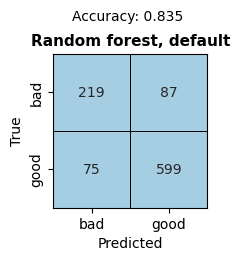

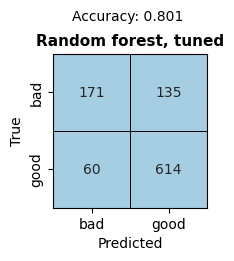

Performance metrix: Default model
      Metric  Train  Test
0   Accuracy  1.000 0.844
1  Precision  1.000 0.878

Performance metrix: Tuned model
      Metric  Train  Test
0   Accuracy  0.791 0.797
1  Precision  0.803 0.818


In [25]:
# Set the random seed
np.random.seed(123)

# General confusion matrix
print_confusion(rfc_def, 'Random forest, default')
print_confusion(rfc_rand, 'Random forest, tuned')

### Best model
metrixs = compare_models(rfc_def, rfc_rand, X_train, y_train, X_test, y_test)

present_results(metrixs, 'Default model', 'Tuned model')

For this seed looking only at accuracy and precision it does seem that the untuned model is performing better then the tuned model. We will compare the overall performance of all models in the end.

# KNN

K-Nearest Neighbors is used for classification of which white wine is good or bad

Tuning K to find a suiting model

In [27]:
# The KNN function using the 5 nearest neighbors
knn = KNeighborsClassifier() # Which is default value

# Creating lists to analyze error, accuracy and precision based on K
error_rate = []
acc = []
prec = []

for i in range(1,40):
     knn = KNeighborsClassifier(n_neighbors=i)
     knn.fit(X_train,y_train)
     pred_i = knn.predict(X_test)
     error_rate.append(np.mean(pred_i != y_test))
     acc.append(accuracy_score(y_test, pred_i))
     prec.append(precision_score(y_test, pred_i))

# A part of this function will depreciate in 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Figure 4 - K-value metrics
Plotting performance based on K-values

Minimum error:  0.23673469387755103 at K = 0
Maximum accuracy:  0.763265306122449 at K = 0
Maximum precision:  0.8446215139442231 at K = 1


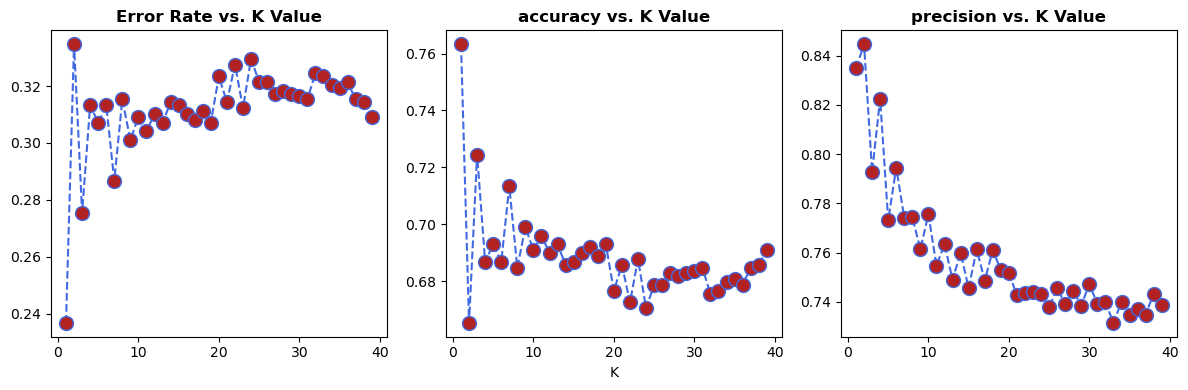

In [27]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

axs[0].plot(range(1,40), error_rate, color='royalblue', linestyle='dashed', 
         marker='o', markerfacecolor='firebrick', markersize=10)
axs[0].set_title('Error Rate vs. K Value', fontweight="bold")
print("Minimum error: ", min(error_rate),"at K =", error_rate.index(min(error_rate)))

    
axs[1].plot(range(1,40), acc, color = 'royalblue', linestyle='dashed', 
         marker='o', markerfacecolor='firebrick', markersize=10)
axs[1].set_title('accuracy vs. K Value', fontweight="bold")
axs[1].set_xlabel('K')
print("Maximum accuracy: ", max(acc),"at K =", acc.index(max(acc)))


axs[2].plot(range(1,40), prec, color = 'royalblue', linestyle='dashed', 
         marker='o', markerfacecolor='firebrick', markersize=10)
axs[2].set_title('precision vs. K Value', fontweight="bold")
print("Maximum precision: ", max(prec), "at K =", prec.index(max(prec)))

plt.tight_layout()
plt.savefig(f'plots/knn_performance.png', dpi=300, bbox_inches='tight')
plt.show()

For our model we pick K=5 as it seems to maximize the accuracy and precision and minimizing the error rate. 

Evaluating performance

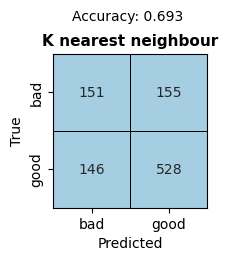

In [30]:
np.random.seed(123)

knn_model = KNeighborsClassifier(n_neighbors=5)

print_confusion(knn_model, 'K nearest neighbour')

# Logistic regression

Creating model based on tuning

In [30]:
# Creating default model
logreg_def = LogisticRegression()

# Creating model for tuning
logreg = LogisticRegression()


# Tuning parameters  
# Penalty term
penalty = ['l1', 'l2']

# Inverse of regularzation strength
C = np.logspace(-4, 4, 20)

#Optimizer - other optimizer not suitable
solver = ['liblinear']

# Number of max iterations
max_iter = [100, 1000, 2500]


# Create the param grid
param_grid_log = {'penalty': penalty,
               'C': C,
               'solver': solver,
               'max_iter': max_iter}

# Set the random seed
np.random.seed(123)

logreg_grid =  GridSearchCV(logreg, param_grid  = param_grid_log, cv = 3, verbose = True, n_jobs = 10)
best_logreg = logreg_grid.fit(X_train, y_train)
print(best_logreg.best_params_)


# Suppress convergence warnings - this is the model found from tuning, generates error for convergence
# Supress warning to make clearer output, but we are aware of the error
warnings.filterwarnings("ignore", category=ConvergenceWarning) 
logreg_grid = LogisticRegression(solver = 'liblinear', max_iter = 2500, C = 1.62, penalty = 'l1')



Fitting 3 folds for each of 120 candidates, totalling 360 fits
{'C': 1.623776739188721, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}


Comparing models

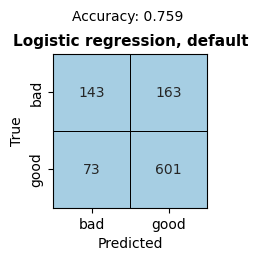

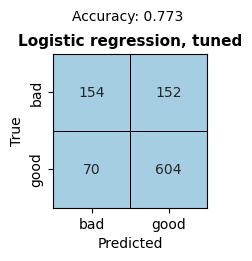

Performance metrix: Default model
      Metric  Train  Test
0   Accuracy  0.738 0.759
1  Precision  0.760 0.787

Performance metrix: Tuned model
      Metric  Train  Test
0   Accuracy  0.749 0.773
1  Precision  0.774 0.801


In [31]:
# General confusion matrix
print_confusion(logreg_def, 'Logistic regression, default')
print_confusion(logreg_grid, 'Logistic regression, tuned')

# Comparing results
metrixs = compare_models(logreg_def, logreg_grid, X_train, y_train, X_test, y_test)

present_results(metrixs, 'Default model', 'Tuned model')

For this seed looking only at accuracy and precision it does seem that the untuned model is performing better then the tuned model. We will compare the overall performance of all models in the end.

# Comparing models

### Figure 7 - ROC curve of the Models
Comparing models with ROC curve

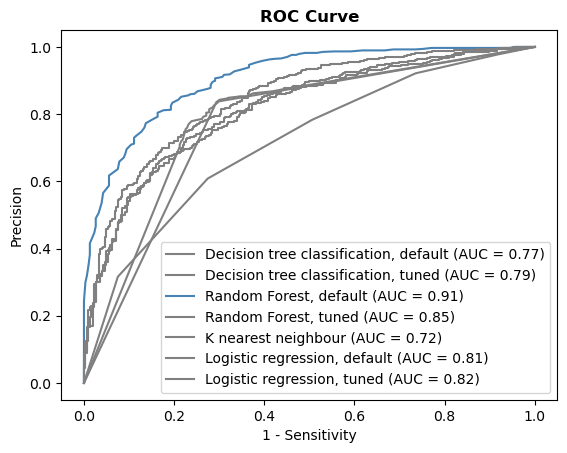

In [32]:
# Fitting 
dtc_def = dtc_def.fit(X_train, y_train)
dtc_rand = dtc_rand.fit(X_train, y_train)

rfc_def = rfc_def.fit(X_train, y_train)
rfc_rand = rfc_rand.fit(X_train, y_train)

knn_model = knn_model.fit(X_train, y_train)

logreg_def = logreg_def.fit(X_train, y_train)
logreg_grid = logreg_grid.fit(X_train, y_train)


# Compute the predicted probabilities for the test data
probs_dtc_def = dtc_def.predict_proba(X_test)[:, 1]
probs_dtc_rand = dtc_rand.predict_proba(X_test)[:, 1]

probs_rfc_def = rfc_def.predict_proba(X_test)[:, 1]
probs_rfc_rand = rfc_rand.predict_proba(X_test)[:, 1]

probs_knn = knn_model.predict_proba(X_test)[:, 1]

probs_lr_def = logreg_def.predict_proba(X_test)[:, 1]
probs_lr_grid = logreg_grid.predict_proba(X_test)[:, 1]


# Compute the true positive rate and false positive rate for each model
fpr_dtc_def, tpr_dtc_def, _ = roc_curve(y_test, probs_dtc_def)
fpr_dtc_rand, tpr_dtc_rand, _ = roc_curve(y_test, probs_dtc_rand)

fpr_rfc_def, tpr_rfc_def, _ = roc_curve(y_test, probs_rfc_def)
fpr_rfc_rand, tpr_rfc_rand, _ = roc_curve(y_test, probs_rfc_rand)

fpr_knn, tpr_knn, _ = roc_curve(y_test, probs_knn)

fpr_lr_def, tpr_lr_def, _ = roc_curve(y_test, probs_lr_def)
fpr_lr_grid, tpr_lr_grid, _ = roc_curve(y_test, probs_lr_grid)

# Compute the AUC score for each model
auc_dtc_def = roc_auc_score(y_test, probs_dtc_def)
auc_dtc_rand = roc_auc_score(y_test, probs_dtc_rand)

auc_rfc_def = roc_auc_score(y_test, probs_rfc_def)
auc_rfc_rand = roc_auc_score(y_test, probs_rfc_rand)

auc_knn = roc_auc_score(y_test, probs_knn)

auc_lr_def = roc_auc_score(y_test, probs_lr_def)
auc_lr_grid = roc_auc_score(y_test, probs_lr_grid)



# Create the ROC curve plot
plt.plot(fpr_dtc_def, tpr_dtc_def, label='Decision tree classification, default (AUC = %0.2f)' % auc_dtc_def, color = "Grey")
plt.plot(fpr_dtc_rand, tpr_dtc_rand, label='Decision tree classification, tuned (AUC = %0.2f)' % auc_dtc_rand, color = "Grey")

plt.plot(fpr_rfc_def, tpr_rfc_def, label='Random Forest, default (AUC = %0.2f)' % auc_rfc_def, color = blue_color)
plt.plot(fpr_rfc_rand, tpr_rfc_rand, label='Random Forest, tuned (AUC = %0.2f)' % auc_rfc_rand, color = "Grey")

plt.plot(fpr_knn, tpr_knn, label='K nearest neighbour (AUC = %0.2f)' % auc_knn, color = "Grey")

plt.plot(fpr_lr_def, tpr_lr_def, label='Logistic regression, default (AUC = %0.2f)' % auc_lr_def, color = "Grey")
plt.plot(fpr_lr_grid, tpr_lr_grid, label='Logistic regression, tuned (AUC = %0.2f)' % auc_lr_grid, color = "Grey")

# Add labels and title to the plot
plt.xlabel('1 - Sensitivity')
plt.ylabel('Precision')
plt.title('ROC Curve', fontweight="bold")
plt.legend()

# Saving figure
plt.savefig(f'plots/auc_curve.png', dpi=300, bbox_inches='tight')


# Show the plot
plt.show()


We notice that for both precision and sensitivity and default Random forest is performing better for all cut off values. This is also indicated by the highest AUC (0.91)

In [33]:
# Storing all models in dictionary with same parameters as default and tuned

# Suppress convergence warnings from tuned logistic regression model
warnings.filterwarnings("ignore", category=ConvergenceWarning) ## NOT SURE ABOUT THIS

models = {
    'Decision Tree, default' : DecisionTreeClassifier(),
    'Decision Tree, tuned' : DecisionTreeClassifier(min_samples_split = 2,
                                   max_features = 'sqrt',
                                   max_depth = 15,
                                   criterion = 'gini'),
    
    
    'Random Forest, default' : RandomForestClassifier(),
    'Random Forest, tund' : RandomForestClassifier(n_estimators=33,
                                   min_samples_split=3,
                                   max_features = 'sqrt',
                                   max_depth = 5,
                                   min_samples_leaf = 2,
                                   bootstrap = True),


    'KNN' : KNeighborsClassifier(n_neighbors=5),


    'Logistic Regression, default' : LogisticRegression(),
    'Logistic Regression, tuned' : LogisticRegression(solver = 'liblinear', max_iter = 1000, C = 1.63, penalty = 'l1')

    
}

In [34]:
# Plotting boxplot function

def plot_boxplots(results, means, names, title):
    
    # Find the indices of the sorted means
    sorted_mean_indices = np.argsort(means)[::-1]

    # Sort the names and results lists based on the sorted mean indices
    sorted_names = [names[i] for i in sorted_mean_indices]
    sorted_results = [results[i] for i in sorted_mean_indices]

    # Create the boxplot
    fig, ax = plt.subplots(figsize=(8, 4))
    bp = ax.boxplot(sorted_results, labels=sorted_names, patch_artist=True, widths=0.5)

    # Color the boxes
    colors = [blue_color if i == 0 else red_color for i in range(len(sorted_names))]
    for patch, color in zip(bp['boxes'], colors):
        patch.set(facecolor=color, edgecolor='black')

    for median in bp['medians']:
        median.set_color('black')

    # Set x-axis label rotation
    plt.xticks(rotation=45)

    # Add title and show the plot
    plt.title(title, fontweight="bold")

    # Saving figure
    plt.savefig(f'plots/{title}.png', dpi=300, bbox_inches='tight')

    
    plt.show()


### Figure 6 - Accuracy and Precision of the Models

Decision Tree, default: 0.783 (0.022)
Decision Tree, tuned: 0.765 (0.027)
Random Forest, default: 0.834 (0.027)
Random Forest, tund: 0.765 (0.029)
KNN: 0.702 (0.027)
Logistic Regression, default: 0.739 (0.021)
Logistic Regression, tuned: 0.746 (0.025)


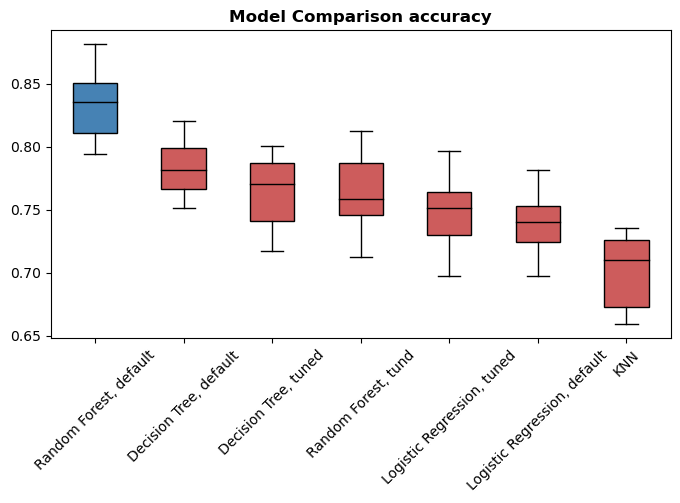

In [35]:
# Evaluate the models using cross-validation

# Evaluate the models using cross-validation
results = []
means = []
sds = []
names = []

np.random.seed(123)
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=15, scoring='accuracy', error_score=0)
    results.append(scores)
    names.append(name)
    means.append(np.mean(scores))
    sds.append(np.std(scores))
    print(f"{name}: {np.mean(scores):.3f} ({np.std(scores):.3f})")


plot_boxplots(results, means, names, 'Model Comparison accuracy')

Decision Tree, default: 0.834 (0.019)
Decision Tree, tuned: 0.819 (0.024)
Random Forest, default: 0.855 (0.023)
Random Forest, tund: 0.790 (0.022)
KNN: 0.748 (0.019)
Logistic Regression, default: 0.760 (0.017)
Logistic Regression, tuned: 0.771 (0.018)


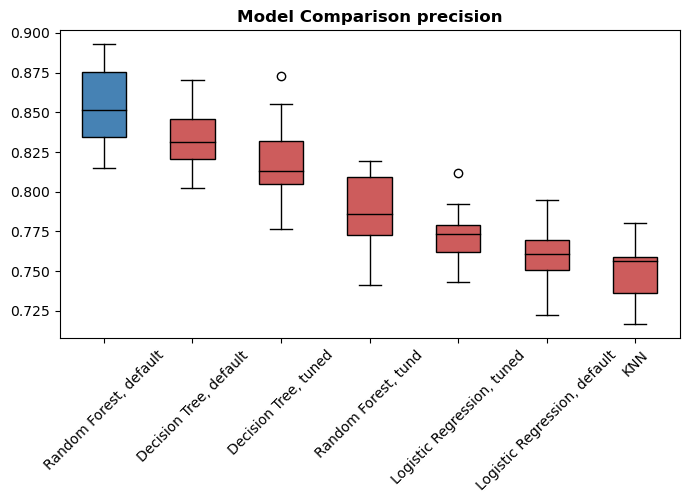

In [36]:
# Evaluate the models using cross-validation: Precision
results = []
means = []
sds = []
names = []

np.random.seed(123)
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=15, scoring='precision', error_score=0)
    results.append(scores)
    names.append(name)
    means.append(np.mean(scores))
    sds.append(np.std(scores))
    print(f"{name}: {np.mean(scores):.3f} ({np.std(scores):.3f})")


plot_boxplots(results, means, names, 'Model Comparison precision')

We see from that for 15 folds the default Random forest model is performing better on average for better accuracy and precision.